# Section 5.1 — Introduction to Bayesian statistics

This notebook contains the code examples from [Section 5.1 Introduction to Bayesian statistics]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayesian/intro"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

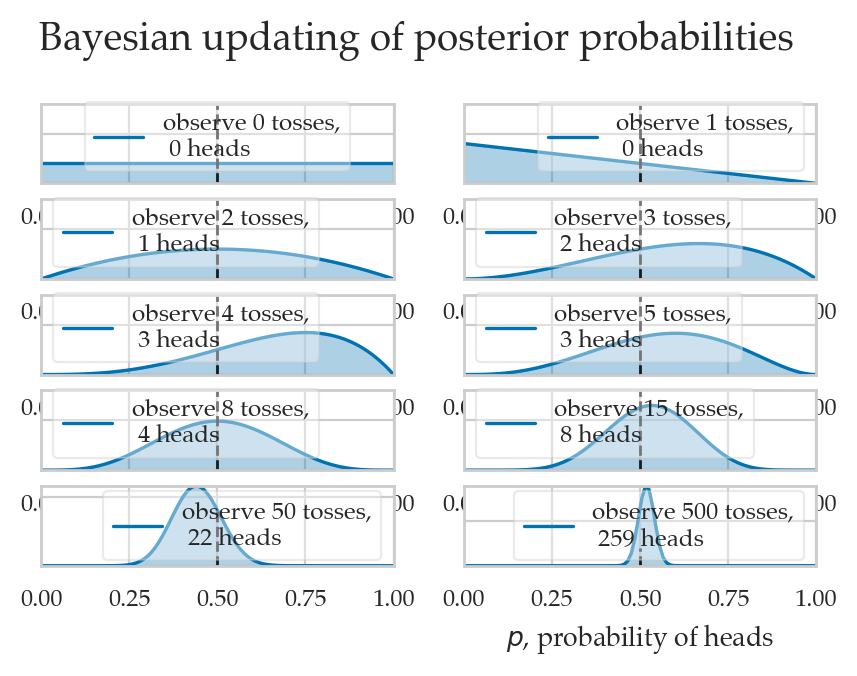

In [4]:
# via https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers
# /blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb
from scipy.stats import beta
from scipy.stats import bernoulli

n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# For the already prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials)//2, 2, k+1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = beta.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14);

## Example 1: estimating the probability of a biased coin

In [5]:
from scipy.special import binom, betaln

def beta_binom(prior, y):
    """
    Compute the marginal-log-likelihood for a beta-binomial model,
    analytically.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    α, β = prior
    success = np.sum(y)
    trials = len(y)
    return np.log(binom(trials, success)) + betaln(α + success, β+trials-success) - betaln(α, β)

In [6]:
from scipy import stats


def beta_binom_harmonic(prior, y, s=10000):
    """
    Compute the marginal-log-likelihood for a beta-binomial model,
    using the harmonic mean estimator.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    s : int
        number of samples from the posterior
    """
    α, β = prior
    success = np.sum(y)
    trials = len(y)
    posterior_samples = stats.beta(α + success, β+trials-success).rvs(s)
    log_likelihood = stats.binom.logpmf(success, trials, posterior_samples)
    return 1/np.mean(1/log_likelihood)

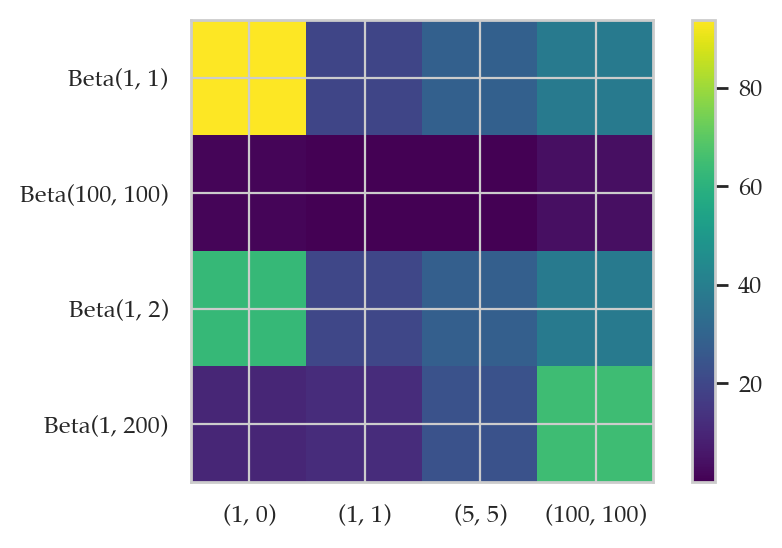

In [7]:
data = [np.repeat([1, 0], rep)
        for rep in ((1, 0), (1, 1), (5, 5), (100, 100))]
priors = ((1, 1), (100, 100), (1, 2), (1, 200))

x_names = [repr((sum(x), len(x)-sum(x))) for x in data]
y_names = ["Beta" + repr(x) for x in priors]

fig, ax = plt.subplots()
error_matrix = np.zeros((len(priors), len(data)))
for i, prior in enumerate(priors):
    for j, y in enumerate(data):
        error_matrix[i, j] = 100 * \
            (1 - (beta_binom_harmonic(prior, y) / beta_binom(prior, y)))
im = ax.imshow(error_matrix, cmap='viridis')
ax.set_xticks(np.arange(len(x_names)))
ax.set_yticks(np.arange(len(y_names)))
ax.set_xticklabels(x_names)
ax.set_yticklabels(y_names)
fig.colorbar(im)
# plt.savefig("img/chp11/harmonic_mean_heatmap.png")

In [8]:
def normal_harmonic(sd_0, sd_1, y, s=10000):
    post_tau = 1/sd_0**2 + 1/sd_1**2
    posterior_samples = stats.norm(loc=(y/sd_1**2)/post_tau, scale=(1/post_tau)**0.5).rvs((s, len(x)))
    log_likelihood = stats.norm.logpdf(loc=x, scale=sd_1, x=posterior_samples).sum(1)
    return 1/np.mean(1/log_likelihood)

In [9]:
σ_0 = 1
σ_1 = 1
y = np.array([0])
stats.norm.logpdf(loc=0, scale=(σ_0**2+σ_1**2)**0.5, x=y).sum()

-1.2655121234846454

In [10]:
def posterior_ml_ic_normal(σ_0=1, σ_1=1, y=[1]):
    n = len(y)
    var_μ = 1/((1/σ_0**2) + (n/σ_1**2))
    μ = var_μ * np.sum(y)/σ_1**2
    σ_μ = var_μ**0.5

    posterior = stats.norm(loc=μ, scale=σ_μ)
    samples = posterior.rvs(size=(2, 1000))
    log_likelihood = stats.norm(loc=samples[:, :, None], scale=σ_1).logpdf(y)
    idata = az.from_dict(log_likelihood={'o': log_likelihood})

    log_ml = stats.norm.logpdf(loc=0, scale=(σ_0**2+σ_1**2)**0.5, x=y).sum()
    
    x = np.linspace(-5, 6, 300)
    density = posterior.pdf(x)
    
    return μ, σ_μ, x, density, log_ml, az.waic(idata).elpd_waic, az.loo(idata, reff=1).elpd_loo

Text(0.5, 0, 'μ')

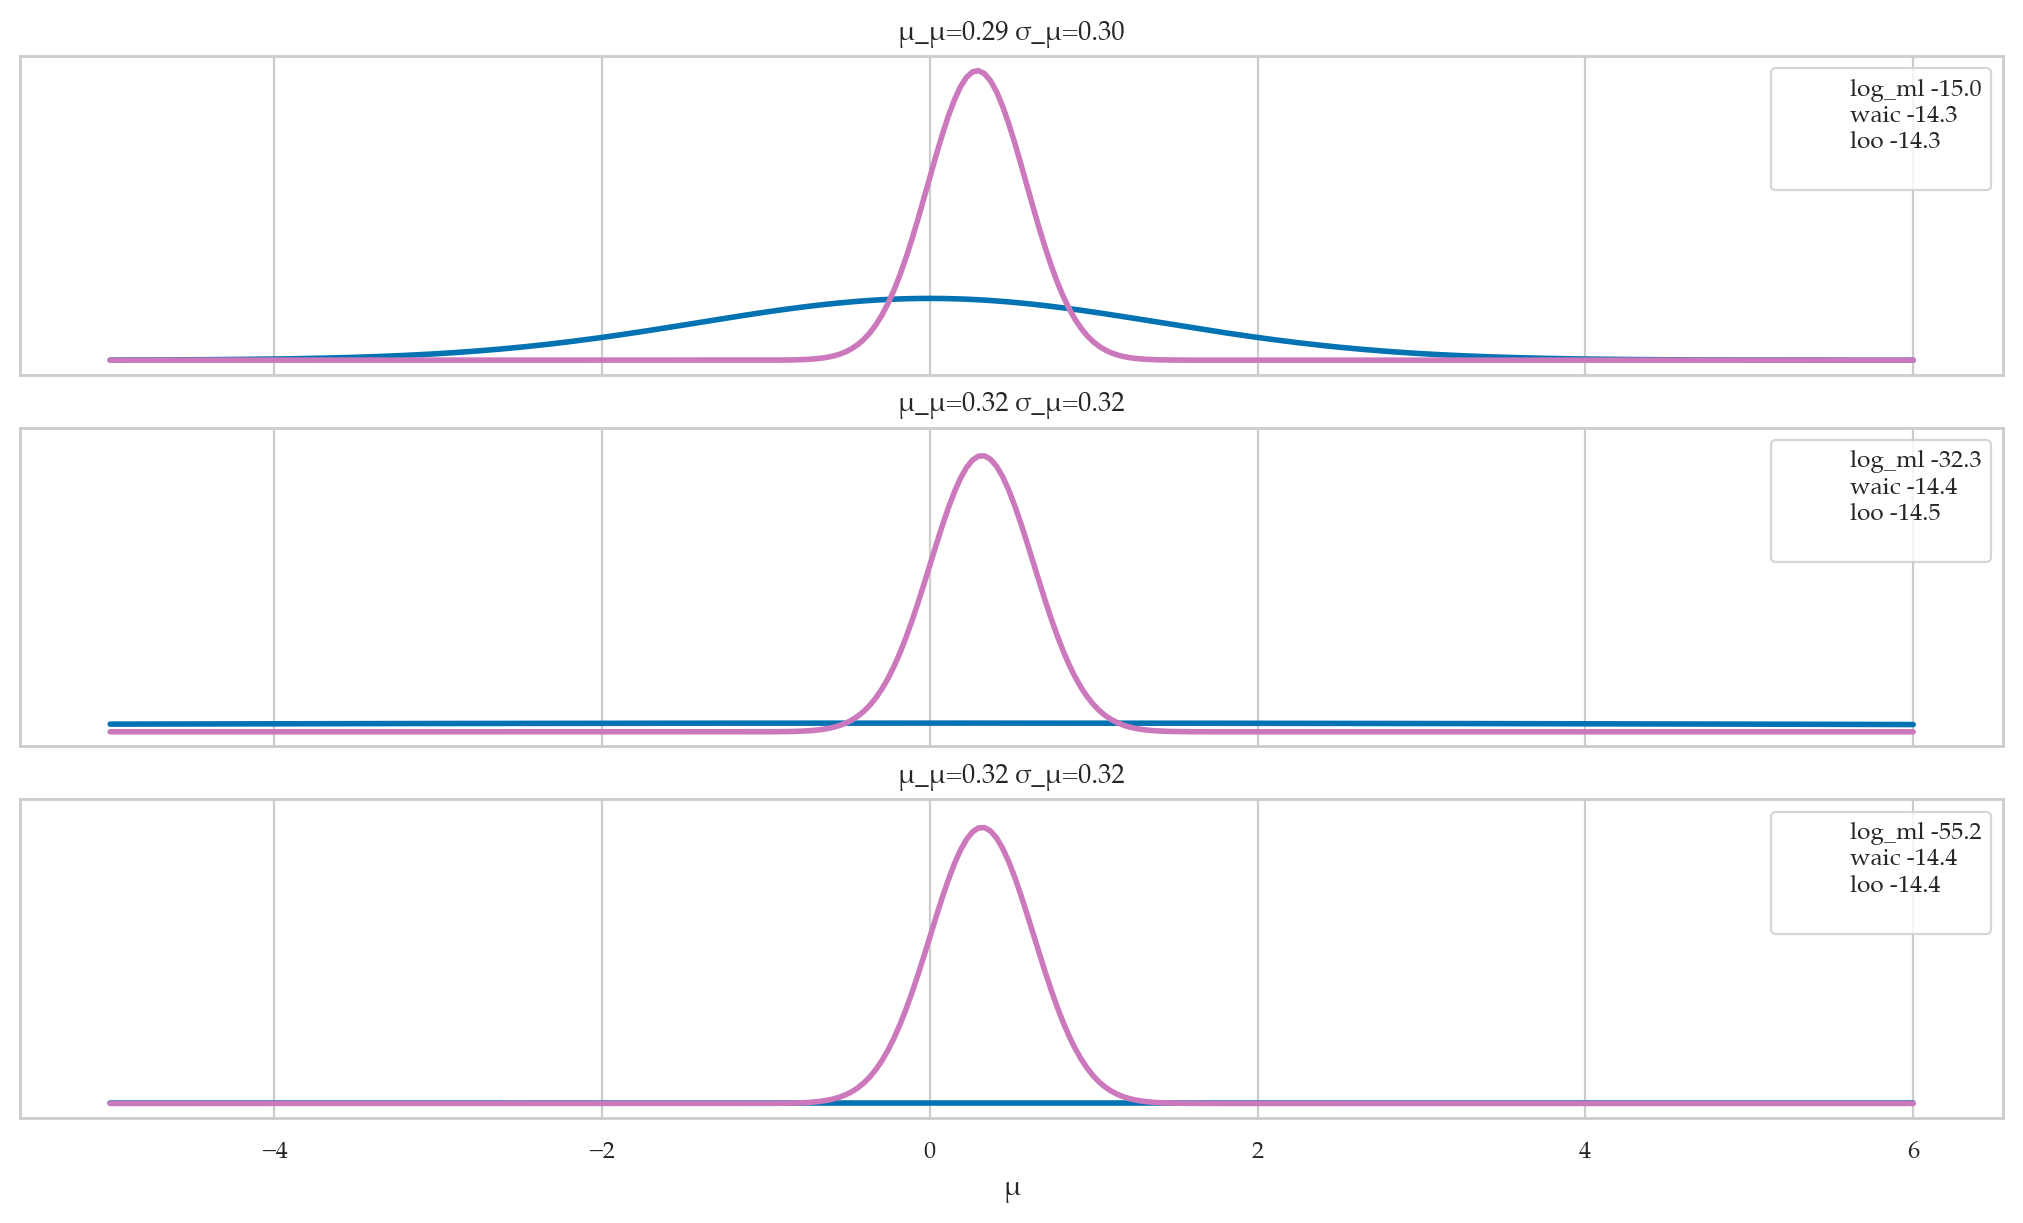

In [11]:
import arviz as az

y = np.array([ 0.65225338, -0.06122589,  0.27745188,  1.38026371, -0.72751008,
              -1.10323829,  2.07122286, -0.52652711,  0.51528113,  0.71297661])

_, ax = plt.subplots(3, figsize=(10, 6), sharex=True, sharey=True,
                     constrained_layout=True)

for i, σ_0 in enumerate((1, 10, 100)):
    μ_μ, σ_μ, x, density, log_ml, waic, loo = posterior_ml_ic_normal(σ_0, σ_1, y)
    ax[i].plot(x, stats.norm(loc=0, scale=(σ_0**2+σ_1**2)**0.5).pdf(x), lw=2)
    ax[i].plot(x, density, lw=2, color='C4')
    ax[i].plot(0, label=f'log_ml {log_ml:.1f}\nwaic {waic:.1f}\nloo {loo:.1f}\n', alpha=0)
    ax[i].set_title(f'μ_μ={μ_μ:.2f} σ_μ={σ_μ:.2f}')
    ax[i].legend()
ax[2].set_yticks([])

ax[2].set_xlabel("μ")

#plt.savefig("img/chp11/ml_waic_loo.png")

In [12]:
σ_0 = 1
σ_1 = 1
y = np.array([0])
stats.norm.logpdf(loc=0, scale=(σ_0**2 + σ_1**2)**0.5, x=y).sum()

-1.2655121234846454

In [13]:
N = 10000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi) * 100

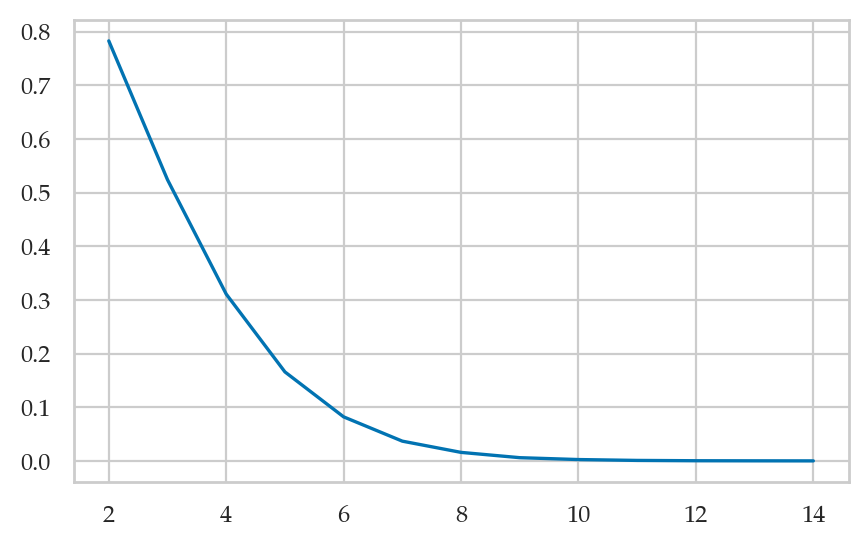

In [14]:
total = 100000

dims = []
prop = []
for d in range(2, 15):
    x = np.random.random(size=(d, total))
    inside = ((x * x).sum(axis=0) < 1).sum()
    dims.append(d)
    prop.append(inside / total)
    
plt.plot(dims, prop);

In [15]:
def posterior_grid(ngrid=10, α=1, β=1, heads=6, trials=9):
    grid = np.linspace(0, 1, ngrid)
    prior = stats.beta(α, β).pdf(grid)
    likelihood = stats.binom.pmf(heads, trials, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return posterior